In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import random
from tensorflow.keras import layers
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
current_dir = os.getcwd()
print(current_dir)

/Users/giulio/Desktop/TESI


In [3]:
base_dir = "/Users/giulio/Desktop/TESI/data/LAG"
print(base_dir)

/Users/giulio/Desktop/TESI/data/LAG


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from shutil import rmtree

data_dir = current_dir + "//model//LAG"
train_dir = data_dir + "//train"
test_dir = data_dir + "//test" 
val_dir = data_dir + "//val"

if os.path.exists(data_dir):
	rmtree(data_dir)

# Definisci la proporzione di suddivisione (es: 0.7 per il 70% nel train e il 30% nel test + val)
train_ratio = 0.7
# Definisci la proporzione di suddivisione del set di test (50% in test e 50% in val)
test_val_ratio = 0.5

# Crea le cartelle train, test e val se non esistono
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Per ogni classe nella cartella dataset
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        # Crea le sottocartelle per ogni classe nelle cartelle train, test e val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Ottieni la lista delle immagini
        images = os.listdir(class_path)

        # Dividi in train e test+val
        train_images, test_val_images = train_test_split(images, train_size=train_ratio, random_state=42)

        # Dividi ulteriormente test+val in test e val
        test_images, val_images = train_test_split(test_val_images, train_size=test_val_ratio, random_state=42)

        # Sposta le immagini nella rispettiva cartella
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

print("Divisione train, test e val completata!")

Divisione train, test e val completata!


In [5]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train.flow_from_directory(
    'model//LAG//train',
    class_mode='categorical',
    shuffle=False)

val_ds = datagen.flow_from_directory(
    'model//LAG//val',
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'model//LAG//test',
    class_mode='categorical',
    shuffle=False)


Found 3396 images belonging to 2 classes.
Found 729 images belonging to 2 classes.
Found 729 images belonging to 2 classes.


In [6]:
print(train_ds.samples)

3396


In [7]:
# bilanciamento del dataset
from sklearn.utils import class_weight
import numpy as np

# Calcola i pesi delle classi
labels = train_ds.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


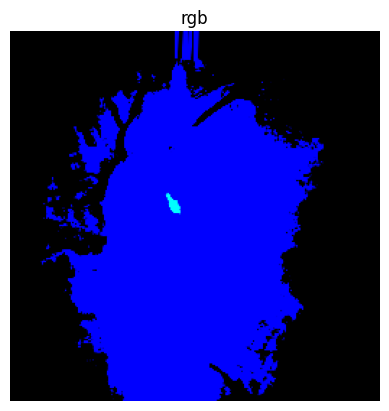

In [8]:
# Retrieve a batch of images and labels
images, labels = next(train_ds)

# Display the first image in the batch
plt.imshow(images[0])
plt.title('rgb')
plt.axis('off')  # Turn off axis
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential()

# Congela i pesi del modello base
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.add(base_model)

# # Aggiungi i tuoi livelli fully connected alla fine del modello base
# model.add(Flatten())
# model.add(Dense(256, activation=silu))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))  # 1 neurone di output con attivazione sigmoid per 2 classi

# Full connection
model.add(Flatten())
model.add(Dense(units = 1028, activation = 'relu'))
model.add(BatchNormalization()),
model.add(Dense(512,activation='relu')),
model.add(Dropout(0.25)),
model.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.00001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 50

# Train the model
model_info = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 556s 5s/step - accuracy: 0.6033 - loss: 0.8004 - val_accuracy: 0.6900 - val_loss: 0.6811 - learning_rate: 1.0000e-05
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - accuracy: 0.8325 - loss: 0.3638 - val_accuracy: 0.7366 - val_loss: 0.5428 - learning_rate: 1.0000e-05
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.9242 - loss: 0.2008 - val_accuracy: 0.7874 - val_loss: 0.4601 - learning_rate: 1.0000e-05
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.9653 - loss: 0.1153 - val_accuracy: 0.7654 - val_loss: 0.4778 - learning_rate: 1.0000e-05
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.9796 - loss: 0.0755 - val_accuracy: 0.8107 - val_loss: 0.3924 - learning_rate: 1.0000e-05
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 472s 4s/step - accuracy: 0.9819 - loss: 0.0611 - val_accuracy: 0.7805 - val_loss: 0.4780 - learning_rate: 1.0000e-05
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - acc

In [13]:
# model.save('my_model.h5')

In [14]:
print(model_info.history['accuracy'])

[0.6675500869750977, 0.870141327381134, 0.9428739547729492, 0.9705535769462585, 0.9776207208633423, 0.9849823117256165, 0.9891048073768616, 0.9923439621925354, 0.9955830574035645, 0.9961719512939453, 0.9941107034683228, 0.9979387521743774, 0.9970553517341614, 0.996760904788971, 0.996760904788971]


In [15]:
print(model_info.history['val_accuracy'])

[0.6899862885475159, 0.7366254925727844, 0.7873799800872803, 0.7654321193695068, 0.8106995820999146, 0.7805212736129761, 0.7860082387924194, 0.8106995820999146, 0.8120713233947754, 0.8134430646896362, 0.8106995820999146, 0.8038408756256104, 0.8038408756256104, 0.806584358215332, 0.806584358215332]


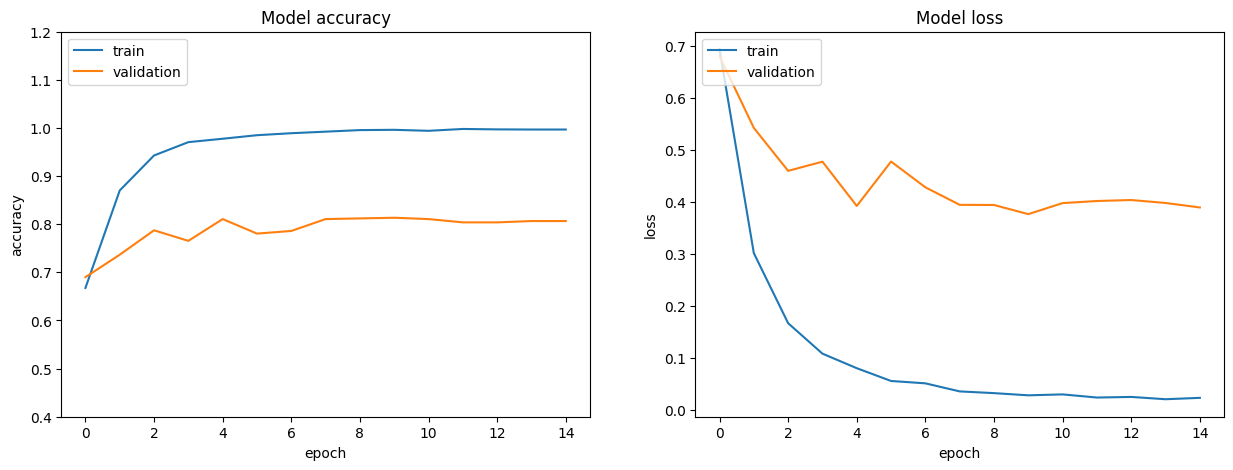

In [16]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.4,1.2)
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(model_info)

In [ ]:
# Scongela alcuni dei livelli convoluzionali del modello base per fare fine-tuning
for layer in base_model.layers[-4:]:  # Scongela gli ultimi 4 livelli convoluzionali
    layer.trainable = True

# Ricompila il modello con un learning rate più basso
model.compile(optimizer=RMSprop(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

# Continua l'addestramento con fine-tuning
fine_tuning_epochs = 15
total_epochs = initial_epochs + fine_tuning_epochs

fine_tuning_info = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=model_info.epoch[-1],  # Inizia dal punto in cui l'addestramento precedente si è fermato
    validation_data=test_ds,
    class_weight=class_weights,
)

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1.2)  # Limiti dell'asse y tra 0 e 1
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim(0, 1)
    plt.show()
plot_train_history(fine_tuning_info)

In [ ]:
# model=load_model(classifier)
# print("Glaucoma detection model loaded")

In [ ]:
def glaucoma_prediction(test_image):
  image = img_to_array(test_image)
  image = np.expand_dims(image, axis = 0)
  result = np.argmax(model.predict(image))
  return result

In [ ]:
# glaucoma img
test_image = load_img(origa + '/036.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

In [ ]:
# not glaucoma img
test_image = load_img(origa + '/642.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

In [17]:
# evaluate model accuracy
score=model.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7288 - loss: 0.5199
Loss: 0.3766668736934662 Accuracy: 0.8134430646896362


In [18]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sb

In [19]:
pred= np.round(model.predict(test_ds, verbose=1))
test_labels=test_ds.labels
test_pred_labels=[]
for i in range(len(pred)):
  test_pred_labels.append(np.argmax(pred[i]))
conf_matrix= confusion_matrix(test_pred_labels,test_labels)
print (conf_matrix)

23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step
[[165  44]
 [ 92 428]]


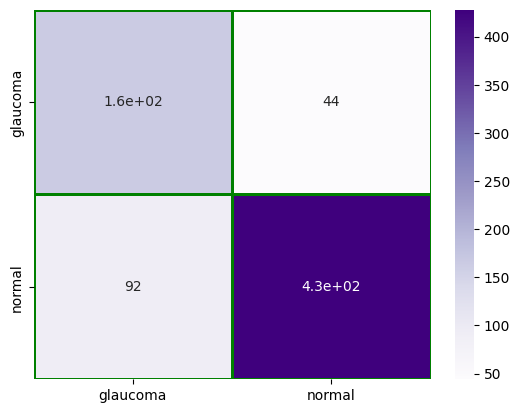

In [20]:
sb.heatmap(conf_matrix,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()


In [21]:
import pandas as pd
test_report = classification_report(test_ds.labels,test_pred_labels, target_names=['glaucoma','normal'], output_dict=True)
test_df = pd.DataFrame(test_report).transpose()
test_df

,precision,recall,f1-score,support
glaucoma,0.789474,0.642023,0.708155,257.000000
normal,0.823077,0.906780,0.862903,472.000000
accuracy,0.813443,0.813443,0.813443,0.813443
macro avg,0.806275,0.774402,0.785529,729.000000
weighted avg,0.811231,0.813443,0.808348,729.000000


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


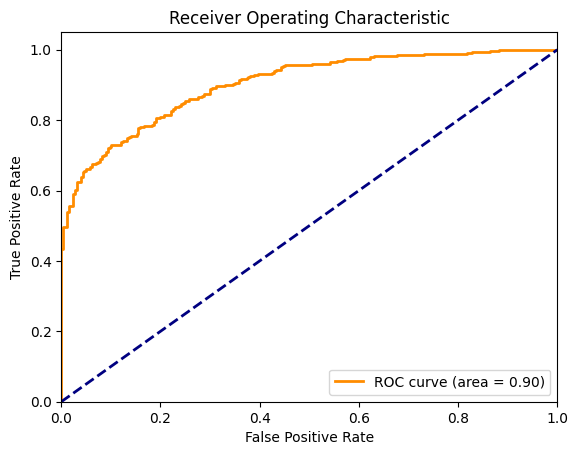

AUC = 0.90


In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch = model.predict(images)
    pred.extend(pred_batch)

# Converti in numpy array
test_labels = np.array(test_labels)
pred = np.array(pred)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred.ndim > 1:
    pred = pred[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr, tpr, _ = roc_curve(test_labels, pred)
roc_auc = auc(fpr, tpr)

# Step 3: Traccia la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.2f' % roc_auc)
